<a href="https://colab.research.google.com/github/supertechnician/Chatbot-using-RNN/blob/main/CHATBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

 
Chatbot Using RNN Model and wikiQA corpus
================
**Author:** `Matthew Inkawhich <https://github.com/MatthewInkawhich>`_



In this tutorial, we explore a fun and interesting use-case of recurrent
sequence-to-sequence models. We will train a simple chatbot using samples from wikiQA corpus.
Corpus <https://www.microsoft.com/en-us/download/details.aspx?id=52419>`__.

Conversational models are a hot topic in artificial intelligence
research. Chatbots can be found in a variety of settings, including
customer service applications and online helpdesks. These bots are often
powered by retrieval-based models, which output predefined responses to
questions of certain forms. In a highly restricted domain like a
company’s IT helpdesk, these models may be sufficient, however, they are
not robust enough for more general use-cases. Teaching a machine to
carry out a meaningful conversation with a human in multiple domains is
a research question that is far from solved. Recently, the deep learning
boom has allowed for powerful generative models like Google’s `Neural
Conversational Model <https://arxiv.org/abs/1506.05869>`__, which marks
a large step towards multi-domain generative conversational models.  

.. 
**Tutorial Highlights**

-  Handle loading and preprocessing of `wikiQA
   Corpus <https://www.microsoft.com/en-us/download/details.aspx?id=52419>`__
   dataset
-  Implement a sequence-to-sequence model with `Luong attention
   mechanism(s) <https://arxiv.org/abs/1508.04025>`__
-  Jointly train encoder and decoder models using mini-batches
-  Implement greedy-search decoding module
-  Interact with trained chatbot

**Acknowledgements**

This tutorial borrows code from the following sources:

1) Yuan-Kuei Wu’s pytorch-chatbot implementation:
   https://github.com/ywk991112/pytorch-chatbot

2) Sean Robertson’s practical-pytorch seq2seq-translation example:
   https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation

3) FloydHub’s Cornell Movie Corpus preprocessing code:
   https://github.com/floydhub/textutil-preprocess-cornell-movie-corpus




Preparations
------------

To start, Download the data ZIP file
`here <https://www.microsoft.com/en-us/download/details.aspx?id=52419>`__
and put the wiki.txt file in a ``data/`` directory under the current directory.

After that, let’s import some necessities.




In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json
import matplotlib.pyplot as plt
import numpy as np

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("/content/drive/My Drive/Colab Notebooks/data", corpus_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load & Preprocess Data
----------------------

The next step is to reformat our data file and load the data into
structures that we can work with.

The WikiQA corpus is a new publicly available set of question and sentence pairs, collected and annotated for research on open-domain question answering. In order to reflect the true information need of general users, we used Bing query logs as the question source. Each question is linked to a Wikipedia page that potentially has the answer. Because the summary section of a Wikipedia page provides the basic and usually most important information about the topic, we used sentences in this section as the candidate answers. With the help of crowdsourcing, we included 3,047 questions and 29,258 sentences in the dataset, where 1,473 sentences were labeled as answer sentences to their corresponding questions. More detail of this corpus can be found in our EMNLP-2015 paper, "WikiQA: A Challenge Dataset for Open-Domain Question Answering" [Yang et al. 2015]. In addition, this download also includes the experimental results in the paper, an evaluation script for judging the "answer triggering" task, as well as the answer phrases labeled by the authors of the paper.

First, we’ll take a look at some lines of our datafile to see the
original format.




# Pre-Processing  wikiQA dataset  

In [ ]:
# Define path to new file
rawDatafile = os.path.join(corpus, "wiki.txt")
datafile = os.path.join(corpus, "formatted_lines.txt")
 
def format_file():
    previousQuestion = ""
    with open(rawDatafile, 'r', encoding='iso-8859-1') as f:
     
        formattedLinesFile = open(
            datafile, "r+", encoding='iso-8859-1')
        for i, line in enumerate(f):
            # for line in f:
            line = line.strip().rstrip()
            if(line[-1] == "1"):

                line = line[:-1]
                line = line.strip().rstrip()
                if(line.split("\t", 1)[0].strip().rstrip() == previousQuestion):
                    print(previousQuestion)

                    formattedLinesFile.write(
                        line.split("\t", 1)[1].strip().rstrip()+" ")
                else:
                   
                    formattedLinesFile.write("\n"+line)
                # print(line)
                previousQuestion = line.split("\t", 1)[0].strip().rstrip()

    formattedLinesFile.close()

format_file()

what does a plus-minus sign mean
what forms seasons
what forms seasons
what are stanzas in poetry
what are the most known sports in america
when did george washington died ?
who makes triumph motorcycles
what are arizona 's symbols
what is the cabin pressure of us airlines
where are colors on stoplight
where are colors on stoplight
where are colors on stoplight
what is gravy made of


In [ ]:
# print("\nWriting newly formatted file...")
# # Print a sample of lines
# print("\nSample lines from file:")
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)
printLines(datafile)

b'\n'
b'how big is bmc software in houston , tx Employing over 6,000 , BMC is often credited with pioneering the BSM concept as a way to help better align IT operations with business needs .\n'
b'how big is bmc software in houston , tx\tFor 2011 , the company recorded an annual revenue of $ 2.1 billion , making it the # 20 largest software company in terms of revenue for that year .\n'
b'how long was i love lucy on the air\tThe black-and-white series originally ran from October 15 , 1951 , to May 6 , 1957 , on the Columbia Broadcasting System ( CBS ) .\n'
b'how did armando christian perez become famous\tArmando P\xc3\xa9rez ( born January 15 , 1981 ) , better known by his stage name Pitbull , is an American rapper , songwriter , and record producer .\n'
b'what bird family is the owl\tOwls are a group of birds that belong to the order Strigiformes , constituting 200 extant bird of prey species .\n'
b'how many people were killed in the oklahoma city bombing\tThe Oklahoma blast claimed 16

Load and trim data
~~~~~~~~~~~~~~~~~~

Our next order of business is to create a vocabulary and load
query/response sentence pairs into memory.

Note that we are dealing with sequences of **words**, which do not have
an implicit mapping to a discrete numerical space. Thus, we must create
one by mapping each unique word that we encounter in our dataset to an
index value.

For this we define a ``Voc`` class, which keeps a mapping from words to
indexes, a reverse mapping of indexes to words, a count of each word and
a total word count. The class provides methods for adding a word to the
vocabulary (``addWord``), adding all words in a sentence
(``addSentence``) and trimming infrequently seen words (``trim``). More
on trimming later.




In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Now we can assemble our vocabulary and query/response sentence pairs.
Before we are ready to use this data, we must perform some
preprocessing.

First, we must convert the Unicode strings to ASCII using
``unicodeToAscii``. Next, we should convert all letters to lowercase and
trim all non-letter characters except for basic punctuation
(``normalizeString``). Finally, to aid in training convergence, we will
filter out sentences with length greater than the ``MAX_LENGTH``
threshold (``filterPairs``).




In [ ]:
MAX_LENGTH = 100  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')

    # print( len(lines) )

    
    # for line in lines:
    #   print(line)
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # for p in pairs:
    #   print(p)
 

    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    # return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH
    return len(p)==2
# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
      if len(pair)==2:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
print(len(pairs))
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 370 sentence pairs
Trimmed to 369 sentence pairs
Counting words...
Counted words: 3862

pairs:
369
['how big is bmc software in houston tx', 'for the company recorded an annual revenue of . billion making it the largest software company in terms of revenue for that year .']
['how long was i love lucy on the air', 'the black and white series originally ran from october to may on the columbia broadcasting system cbs .']
['how did armando christian perez become famous', 'armando perez born january better known by his stage name pitbull is an american rapper songwriter and record producer .']
['what bird family is the owl', 'owls are a group of birds that belong to the order strigiformes constituting extant bird of prey species .']
['how many people were killed in the oklahoma city bombing', 'the oklahoma blast claimed lives including children under the age of and injured more than people .']
['how many xbox games are there', 'there a

Another tactic that is beneficial to achieving faster convergence during
training is trimming rarely used words out of our vocabulary. Decreasing
the feature space will also soften the difficulty of the function that
the model must learn to approximate. We will do this as a two-step
process:

1) Trim words used under ``MIN_COUNT`` threshold using the ``voc.trim``
   function.

2) Filter out pairs with trimmed words.




In [ ]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
       if len(pair)==2:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    # print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs
print("ff")
print(len(pairs))

# Trim voc and pairs
# pairs = trimRareWords(voc, pairs, MIN_COUNT)
print(len(pairs))

ff
369
369


Prepare Data for Models
-----------------------

Although we have put a great deal of effort into preparing and massaging our
data into a nice vocabulary object and list of sentence pairs, our models
will ultimately expect numerical torch tensors as inputs. One way to
prepare the processed data for the models can be found in the `seq2seq
translation
tutorial <https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html>`__.
In that tutorial, we use a batch size of 1, meaning that all we have to
do is convert the words in our sentence pairs to their corresponding
indexes from the vocabulary and feed this to the models.

However, if you’re interested in speeding up training and/or would like
to leverage GPU parallelization capabilities, you will need to train
with mini-batches.

Using mini-batches also means that we must be mindful of the variation
of sentence length in our batches. To accomodate sentences of different
sizes in the same batch, we will make our batched input tensor of shape
*(max_length, batch_size)*, where sentences shorter than the
*max_length* are zero padded after an *EOS_token*.

If we simply convert our English sentences to tensors by converting
words to their indexes(\ ``indexesFromSentence``) and zero-pad, our
tensor would have shape *(batch_size, max_length)* and indexing the
first dimension would return a full sequence across all time-steps.
However, we need to be able to index our batch along time, and across
all sequences in the batch. Therefore, we transpose our input batch
shape to *(max_length, batch_size)*, so that indexing across the first
dimension returns a time step across all sentences in the batch. We
handle this transpose implicitly in the ``zeroPadding`` function.

.. figure:: /_static/img/chatbot/seq2seq_batches.png
   :align: center
   :alt: batches

The ``inputVar`` function handles the process of converting sentences to
tensor, ultimately creating a correctly shaped zero-padded tensor. It
also returns a tensor of ``lengths`` for each of the sequences in the
batch which will be passed to our decoder later.

The ``outputVar`` function performs a similar function to ``inputVar``,
but instead of returning a ``lengths`` tensor, it returns a binary mask
tensor and a maximum target sentence length. The binary mask tensor has
the same shape as the output target tensor, but every element that is a
*PAD_token* is 0 and all others are 1.

``batch2TrainData`` simply takes a bunch of pairs and returns the input
and target tensors using the aforementioned functions.




In [ ]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
print(len(pairs))
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

369
input_variable: tensor([[ 408,   68,  408,  408,   68],
        [  28,  150,  750,  217,  142],
        [2956,   28,   12, 2979, 2199],
        [   4,   12,  751, 2980, 2200],
        [  32,  630,    8, 2981,  382],
        [3197,  631,  752,    2,    2],
        [  35,    2,    2,    0,    0],
        [  12,    0,    0,    0,    0],
        [  89,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([10,  7,  7,  6,  6])
target_variable: tensor([[ 262,   12,   12, 2800,   74],
        [ 340,  630,  753,   74, 2201],
        [2956,  631,  754,  690, 2202],
        [  19, 1774,   12, 2982,    5],
        [   4,   40,  755, 2983,   74],
        [2379,   55,   58,  447, 1432],
        [   5,   42,   12, 1194, 2203],
        [  74, 1317,  756, 2984,   18],
        [3626,    8,   18, 2985,   74],
        [3256,   12,   19, 2980, 2204],
        [2396, 2172,    2,   28, 2205],
        [   8, 2173,    0, 2986,   11],
        [  12,   19,    0,   42, 1749],
    

Define Models
-------------

Seq2Seq Model
~~~~~~~~~~~~~

The brains of our chatbot is a sequence-to-sequence (seq2seq) model. The
goal of a seq2seq model is to take a variable-length sequence as an
input, and return a variable-length sequence as an output using a
fixed-sized model.

`Sutskever et al. <https://arxiv.org/abs/1409.3215>`__ discovered that
by using two separate recurrent neural nets together, we can accomplish
this task. One RNN acts as an **encoder**, which encodes a variable
length input sequence to a fixed-length context vector. In theory, this
context vector (the final hidden layer of the RNN) will contain semantic
information about the query sentence that is input to the bot. The
second RNN is a **decoder**, which takes an input word and the context
vector, and returns a guess for the next word in the sequence and a
hidden state to use in the next iteration.

.. figure:: /_static/img/chatbot/seq2seq_ts.png
   :align: center
   :alt: model

Image source:
https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/




Encoder
~~~~~~~

The encoder RNN iterates through the input sentence one token
(e.g. word) at a time, at each time step outputting an “output” vector
and a “hidden state” vector. The hidden state vector is then passed to
the next time step, while the output vector is recorded. The encoder
transforms the context it saw at each point in the sequence into a set
of points in a high-dimensional space, which the decoder will use to
generate a meaningful output for the given task.

At the heart of our encoder is a multi-layered Gated Recurrent Unit,
invented by `Cho et al. <https://arxiv.org/pdf/1406.1078v3.pdf>`__ in
2014. We will use a bidirectional variant of the GRU, meaning that there
are essentially two independent RNNs: one that is fed the input sequence
in normal sequential order, and one that is fed the input sequence in
reverse order. The outputs of each network are summed at each time step.
Using a bidirectional GRU will give us the advantage of encoding both
past and future context.

Bidirectional RNN:

.. figure:: /_static/img/chatbot/RNN-bidirectional.png
   :width: 70%
   :align: center
   :alt: rnn_bidir

Image source: https://colah.github.io/posts/2015-09-NN-Types-FP/

Note that an ``embedding`` layer is used to encode our word indices in
an arbitrarily sized feature space. For our models, this layer will map
each word to a feature space of size *hidden_size*. When trained, these
values should encode semantic similarity between similar meaning words.

Finally, if passing a padded batch of sequences to an RNN module, we
must pack and unpack padding around the RNN pass using
``nn.utils.rnn.pack_padded_sequence`` and
``nn.utils.rnn.pad_packed_sequence`` respectively.

**Computation Graph:**

   1) Convert word indexes to embeddings.
   2) Pack padded batch of sequences for RNN module.
   3) Forward pass through GRU.
   4) Unpack padding.
   5) Sum bidirectional GRU outputs.
   6) Return output and final hidden state.

**Inputs:**

-  ``input_seq``: batch of input sentences; shape=\ *(max_length,
   batch_size)*
-  ``input_lengths``: list of sentence lengths corresponding to each
   sentence in the batch; shape=\ *(batch_size)*
-  ``hidden``: hidden state; shape=\ *(n_layers x num_directions,
   batch_size, hidden_size)*

**Outputs:**

-  ``outputs``: output features from the last hidden layer of the GRU
   (sum of bidirectional outputs); shape=\ *(max_length, batch_size,
   hidden_size)*
-  ``hidden``: updated hidden state from GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

Decoder
~~~~~~~

The decoder RNN generates the response sentence in a token-by-token
fashion. It uses the encoder’s context vectors, and internal hidden
states to generate the next word in the sequence. It continues
generating words until it outputs an *EOS_token*, representing the end
of the sentence. A common problem with a vanilla seq2seq decoder is that
if we rely soley on the context vector to encode the entire input
sequence’s meaning, it is likely that we will have information loss.
This is especially the case when dealing with long input sequences,
greatly limiting the capability of our decoder.

To combat this, `Bahdanau et al. <https://arxiv.org/abs/1409.0473>`__
created an “attention mechanism” that allows the decoder to pay
attention to certain parts of the input sequence, rather than using the
entire fixed context at every step.

At a high level, attention is calculated using the decoder’s current
hidden state and the encoder’s outputs. The output attention weights
have the same shape as the input sequence, allowing us to multiply them
by the encoder outputs, giving us a weighted sum which indicates the
parts of encoder output to pay attention to. `Sean
Robertson’s <https://github.com/spro>`__ figure describes this very
well:

.. figure:: /_static/img/chatbot/attn2.png
   :align: center
   :alt: attn2

`Luong et al. <https://arxiv.org/abs/1508.04025>`__ improved upon
Bahdanau et al.’s groundwork by creating “Global attention”. The key
difference is that with “Global attention”, we consider all of the
encoder’s hidden states, as opposed to Bahdanau et al.’s “Local
attention”, which only considers the encoder’s hidden state from the
current time step. Another difference is that with “Global attention”,
we calculate attention weights, or energies, using the hidden state of
the decoder from the current time step only. Bahdanau et al.’s attention
calculation requires knowledge of the decoder’s state from the previous
time step. Also, Luong et al. provides various methods to calculate the
attention energies between the encoder output and decoder output which
are called “score functions”:

.. figure:: /_static/img/chatbot/scores.png
   :width: 60%
   :align: center
   :alt: scores

where $h_t$ = current target decoder state and $\bar{h}_s$ =
all encoder states.

Overall, the Global attention mechanism can be summarized by the
following figure. Note that we will implement the “Attention Layer” as a
separate ``nn.Module`` called ``Attn``. The output of this module is a
softmax normalized weights tensor of shape *(batch_size, 1,
max_length)*.

.. figure:: /_static/img/chatbot/global_attn.png
   :align: center
   :width: 60%
   :alt: global_attn




In [ ]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

Now that we have defined our attention submodule, we can implement the
actual decoder model. For the decoder, we will manually feed our batch
one time step at a time. This means that our embedded word tensor and
GRU output will both have shape *(1, batch_size, hidden_size)*.

**Computation Graph:**

   1) Get embedding of current input word.
   2) Forward through unidirectional GRU.
   3) Calculate attention weights from the current GRU output from (2).
   4) Multiply attention weights to encoder outputs to get new "weighted sum" context vector.
   5) Concatenate weighted context vector and GRU output using Luong eq. 5.
   6) Predict next word using Luong eq. 6 (without softmax).
   7) Return output and final hidden state.

**Inputs:**

-  ``input_step``: one time step (one word) of input sequence batch;
   shape=\ *(1, batch_size)*
-  ``last_hidden``: final hidden layer of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*
-  ``encoder_outputs``: encoder model’s output; shape=\ *(max_length,
   batch_size, hidden_size)*

**Outputs:**

-  ``output``: softmax normalized tensor giving probabilities of each
   word being the correct next word in the decoded sequence;
   shape=\ *(batch_size, voc.num_words)*
-  ``hidden``: final hidden state of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*




In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

Define Training Procedure
-------------------------

Masked loss
~~~~~~~~~~~

Since we are dealing with batches of padded sequences, we cannot simply
consider all elements of the tensor when calculating loss. We define
``maskNLLLoss`` to calculate our loss based on our decoder’s output
tensor, the target tensor, and a binary mask tensor describing the
padding of the target tensor. This loss function calculates the average
negative log likelihood of the elements that correspond to a *1* in the
mask tensor.




In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

Single training iteration
~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train`` function contains the algorithm for a single training
iteration (a single batch of inputs).

We will use a couple of clever tricks to aid in convergence:

-  The first trick is using **teacher forcing**. This means that at some
   probability, set by ``teacher_forcing_ratio``, we use the current
   target word as the decoder’s next input rather than using the
   decoder’s current guess. This technique acts as training wheels for
   the decoder, aiding in more efficient training. However, teacher
   forcing can lead to model instability during inference, as the
   decoder may not have a sufficient chance to truly craft its own
   output sequences during training. Thus, we must be mindful of how we
   are setting the ``teacher_forcing_ratio``, and not be fooled by fast
   convergence.

-  The second trick that we implement is **gradient clipping**. This is
   a commonly used technique for countering the “exploding gradient”
   problem. In essence, by clipping or thresholding gradients to a
   maximum value, we prevent the gradients from growing exponentially
   and either overflow (NaN), or overshoot steep cliffs in the cost
   function.

.. figure:: /_static/img/chatbot/grad_clip.png
   :align: center
   :width: 60%
   :alt: grad_clip

Image source: Goodfellow et al. *Deep Learning*. 2016. https://www.deeplearningbook.org/

**Sequence of Operations:**

   1) Forward pass entire input batch through encoder.
   2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
   3) Forward input batch sequence through decoder one time step at a time.
   4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
   5) Calculate and accumulate loss.
   6) Perform backpropagation.
   7) Clip gradients.
   8) Update encoder and decoder model parameters.


.. Note ::

  PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
  other non-recurrent layers by simply passing them the entire input
  sequence (or batch of sequences). We use the ``GRU`` layer like this in
  the ``encoder``. The reality is that under the hood, there is an
  iterative process looping over each time step calculating hidden states.
  Alternatively, you ran run these modules one time-step at a time. In
  this case, we manually loop over the sequences during the training
  process like we must do for the ``decoder`` model. As long as you
  maintain the correct conceptual model of these modules, implementing
  sequential models can be very straightforward.





In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

Training iterations
~~~~~~~~~~~~~~~~~~~

It is finally time to tie the full training procedure together with the
data. The ``trainIters`` function is responsible for running
``n_iterations`` of training given the passed models, optimizers, data,
etc. This function is quite self explanatory, as we have done the heavy
lifting with the ``train`` function.

One thing to note is that when we save our model, we save a tarball
containing the encoder and decoder state_dicts (parameters), the
optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
in this way will give us the ultimate flexibility with the checkpoint.
After loading a checkpoint, we will be able to use the model parameters
to run inference, or we can continue training right where we left off.




In [ ]:
lossDictionary={}

def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            lossDictionary[iteration / n_iteration * 100]=print_loss_avg
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
       
        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

Define Evaluation
-----------------

After training a model, we want to be able to talk to the bot ourselves.
First, we must define how we want the model to decode the encoded input.

Greedy decoding
~~~~~~~~~~~~~~~

Greedy decoding is the decoding method that we use during training when
we are **NOT** using teacher forcing. In other words, for each time
step, we simply choose the word from ``decoder_output`` with the highest
softmax value. This decoding method is optimal on a single time-step
level.

To facilite the greedy decoding operation, we define a
``GreedySearchDecoder`` class. When run, an object of this class takes
an input sequence (``input_seq``) of shape *(input_seq length, 1)*, a
scalar input length (``input_length``) tensor, and a ``max_length`` to
bound the response sentence length. The input sentence is evaluated
using the following computational graph:

**Computation Graph:**

   1) Forward input through encoder model.
   2) Prepare encoder's final hidden layer to be first hidden input to the decoder.
   3) Initialize decoder's first input as SOS_token.
   4) Initialize tensors to append decoded words to.
   5) Iteratively decode one word token at a time:
       a) Forward pass through decoder.
       b) Obtain most likely word token and its softmax score.
       c) Record token and score.
       d) Prepare current token to be next decoder input.
   6) Return collections of word tokens and scores.




In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

Evaluate my text
~~~~~~~~~~~~~~~~

Now that we have our decoding method defined, we can write functions for
evaluating a string input sentence. The ``evaluate`` function manages
the low-level process of handling the input sentence. We first format
the sentence as an input batch of word indexes with *batch_size==1*. We
do this by converting the words of the sentence to their corresponding
indexes, and transposing the dimensions to prepare the tensor for our
models. We also create a ``lengths`` tensor which contains the length of
our input sentence. In this case, ``lengths`` is scalar because we are
only evaluating one sentence at a time (batch_size==1). Next, we obtain
the decoded response sentence tensor using our ``GreedySearchDecoder``
object (``searcher``). Finally, we convert the response’s indexes to
words and return the list of decoded words.

``evaluateInput`` acts as the user interface for our chatbot. When
called, an input text field will spawn in which we can enter our query
sentence. After typing our input sentence and pressing *Enter*, our text
is normalized in the same way as our training data, and is ultimately
fed to the ``evaluate`` function to obtain a decoded output sentence. We
loop this process, so we can keep chatting with our bot until we enter
either “q” or “quit”.

Finally, if a sentence is entered that contains a word that is not in
the vocabulary, we handle this gracefully by printing an error message
and prompting the user to enter another sentence.




In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    
    
    # device=GPU


    input_batch = input_batch.to(device)
    lengths = lengths.to('cpu')
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            # #TODO
            # sent_len=10       
            # sentence=[]
            # for count,word in enumerate(output_words):
            #   if (count%sent_len==0 and count>0):
            #     print(' '.join(sentence))
            #     sentence=[]
            #   else:
            #     sentence.append(word)
              
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Please, can you elaborate?")

Run Model
---------

Finally, it is time to run our model!

Regardless of whether we want to train or test the chatbot model, we
must initialize the individual encoder and decoder models. In the
following block, we set our desired configurations, choose to start from
scratch or set a checkpoint to load from, and build and initialize the
models. Feel free to play with different model configurations to
optimize performance.




In [ ]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 1000
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.2
batch_size = 16

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


Run Training
~~~~~~~~~~~~

Run the following block if you want to train the model.

First we set training parameters, then we initialize our optimizers, and
finally we call the ``trainIters`` function to run our training
iterations.




Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.1%; Average loss: 8.2600
Iteration: 2; Percent complete: 0.2%; Average loss: 8.2033
Iteration: 3; Percent complete: 0.4%; Average loss: 8.0775
Iteration: 4; Percent complete: 0.5%; Average loss: 7.8240
Iteration: 5; Percent complete: 0.6%; Average loss: 7.5771
Iteration: 6; Percent complete: 0.8%; Average loss: 7.0212
Iteration: 7; Percent complete: 0.9%; Average loss: 7.5655
Iteration: 8; Percent complete: 1.0%; Average loss: 7.1134
Iteration: 9; Percent complete: 1.1%; Average loss: 7.4559
Iteration: 10; Percent complete: 1.2%; Average loss: 7.2614
Iteration: 11; Percent complete: 1.4%; Average loss: 7.1255
Iteration: 12; Percent complete: 1.5%; Average loss: 6.6843
Iteration: 13; Percent complete: 1.6%; Average loss: 7.3227
Iteration: 14; Percent complete: 1.8%; Average loss: 6.8160
Iteration: 15; Percent complete: 1.9%; Average loss: 6.4370
Iteration: 16; Percent complete: 2.0%

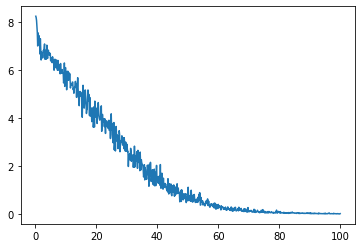

In [ ]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0

n_iteration = 800   # TODO make it 4000

print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
    
# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)



x_axis = np.array(list(lossDictionary.keys()))
y_axis = np.array(list(lossDictionary.values()))
plt.plot(x_axis,y_axis)

Run Evaluation
~~~~~~~~~~~~~~

To chat with your model, run the following block.




In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> What is the the North American Free Trade Agreement ?
Bot: the north american free trade agreement nafta is an agreement signed by canada mexico and the united states creating a trilateral trade bloc in north america . north america in canada and mexico . the state of alaska is west of canada and east of russia across the bering strait and the state of hawaii is in the mid north pacific . the country also has five populated and nine unpopulated territories in the pacific and the caribbean . . in north america . north american people north american time . and one of the
> where is UWA on world list of universities
Bot: one of australia s best and most prestigious universities uwa is highly ranked internationally in various publications the qs world university rankings placed uwa at rd internationally . in each qs of the world . .the country also has five populated and nine unpopulated territories in the pacific and the caribbean . . in one of the most significant global environmental 

Conclusion
----------

That’s all for this one, folks. Congratulations, you now know the
fundamentals to building a generative chatbot model! If you’re
interested, you can try tailoring the chatbot’s behavior by tweaking the
model and training parameters and customizing the data that you train
the model on.

Check out the other tutorials for more cool deep learning applications
in PyTorch!


